In [1]:
##importing libraries
import emcee
import matplotlib.pyplot as plt

In [2]:
## importing results - these were run on a different device
backend = emcee.backends.HDFBackend("Convection_MCMC.h5", name="mcmc", read_only=True)
samples = backend.get_chain()

In [3]:
nsamples, nwalkers, ndim = samples.shape

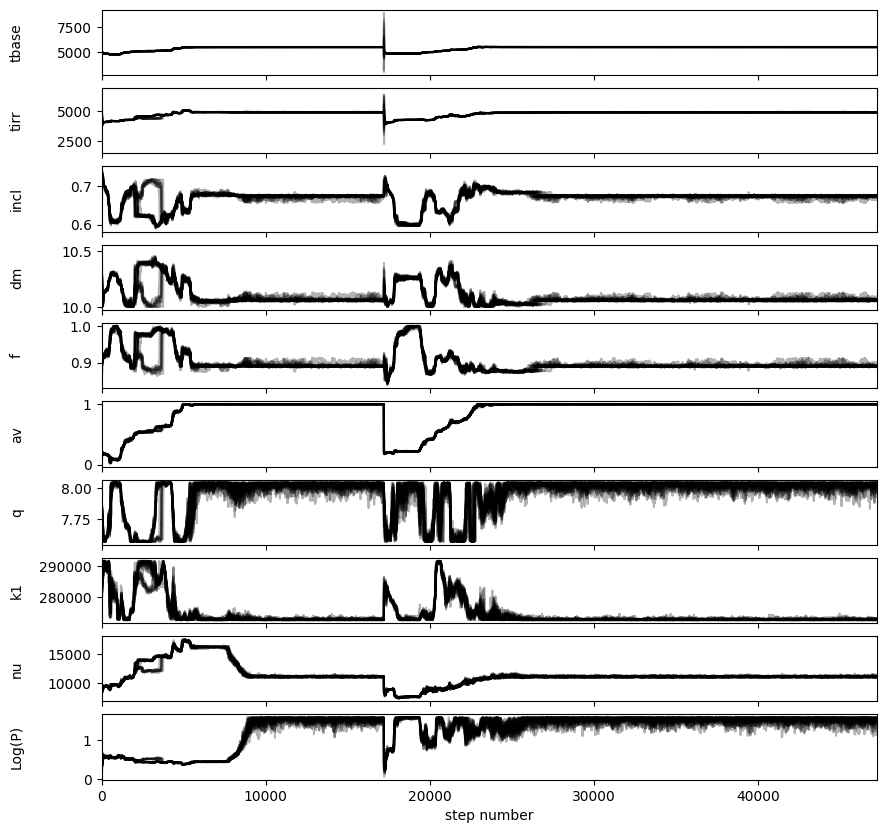

In [197]:
fig, axes = plt.subplots(10, figsize=(10, 10), sharex=True)
labels = ["tbase", "tirr", "incl", "dm", "f", "av", "q", "k1", "nu", "angle", "mpsr", "mcomp"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
ax.set_xlim(0, len(samples))
ax.set_ylabel("Log(P)")
ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [8]:
## Importing more libraries
import emcee
import numpy as np
import matplotlib.pyplot as plt
import Icarus
import astropy.units as u
import healpy as hp
import pyshtools as psh
from multiprocessing import Pool

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display, Math
from matplotlib import rcParams
from scipy.optimize import minimize
import corner

import os
import time

Eclipse.py: The Eclipse module needs updating as it is not compatible with Python 3.x.
Eclipse.py: weave cannot be imported from scipy nor on its own.
Eclipse.py: The Shapely package cannot be imported. This module can but no eclipse optimization can be used.


In [193]:
porb = 0.1980962019*24*60*60 # orbital period
G = 6.674e-11 # gravitational constant
sigq = 0.07939186878204116 # error in q
sigk1 = 9.6 * 1000 # error in K1
msol = 1.98849e30 # solar mass
tbase_true = 5432 # base temp
tirr_true = 4903 # irradiated temp
incl_true = 0.8098328 # inclination
dm_true = 10.501852725587815 # distance modulus
f_true = 0.86 # filling factor
av_true = 0.23 # extincion
q_true = 7.806847695110107 # mass ration
k_true = 282200 # companion radial velocity, k1
nu_true = 8000 # convection coefficient
ang_true = np.pi/8 # convection width
mpsr_true = 1.76 * msol #pulsar mass
mcomp_true = mpsr_true / q_true # companion mass

In [202]:
try:
    tau = sampler.get_autocorr_time()
    print(tau)

except Exception:    
    print('error encountered')

error encountered


In [42]:
flat_samples = backend.get_chain(discard=40000, thin=15, flat=True)
print(flat_samples.shape)

(10560, 10)


In [194]:
flat_samples2 = []
## adding the pulsar and companion stars masses to the stored answers
k = flat_samples[:,7]
q = flat_samples[:,6]
i = flat_samples[:,2]
        
a = (porb * k**3)  
b = (1 +(1/q))**2
        
num = a*b

denom = 2 *np.pi * G * (np.sin(i))**3

mass = num/denom

mpsr = mass/msol

mass1 = []
        
mass1.append(mpsr)

mass2 = []

mcomp = mpsr/q

mass2.append(mcomp)

In [195]:
newmass = np.transpose(mass1, [1,0])
cmass = np.transpose(mass2, [1,0])

print(np.shape(mass1))
print(np.shape(newmass))
print(np.shape(flat_samples))

(1, 10560)
(10560, 1)
(10560, 10)


In [196]:
flat_samples2 = np.concatenate((flat_samples,newmass), axis = 1)
flat_samples3 = np.concatenate((flat_samples2, cmass), axis = 1)

root                           hist2d                   :         WARNING Too few points to create valid contours


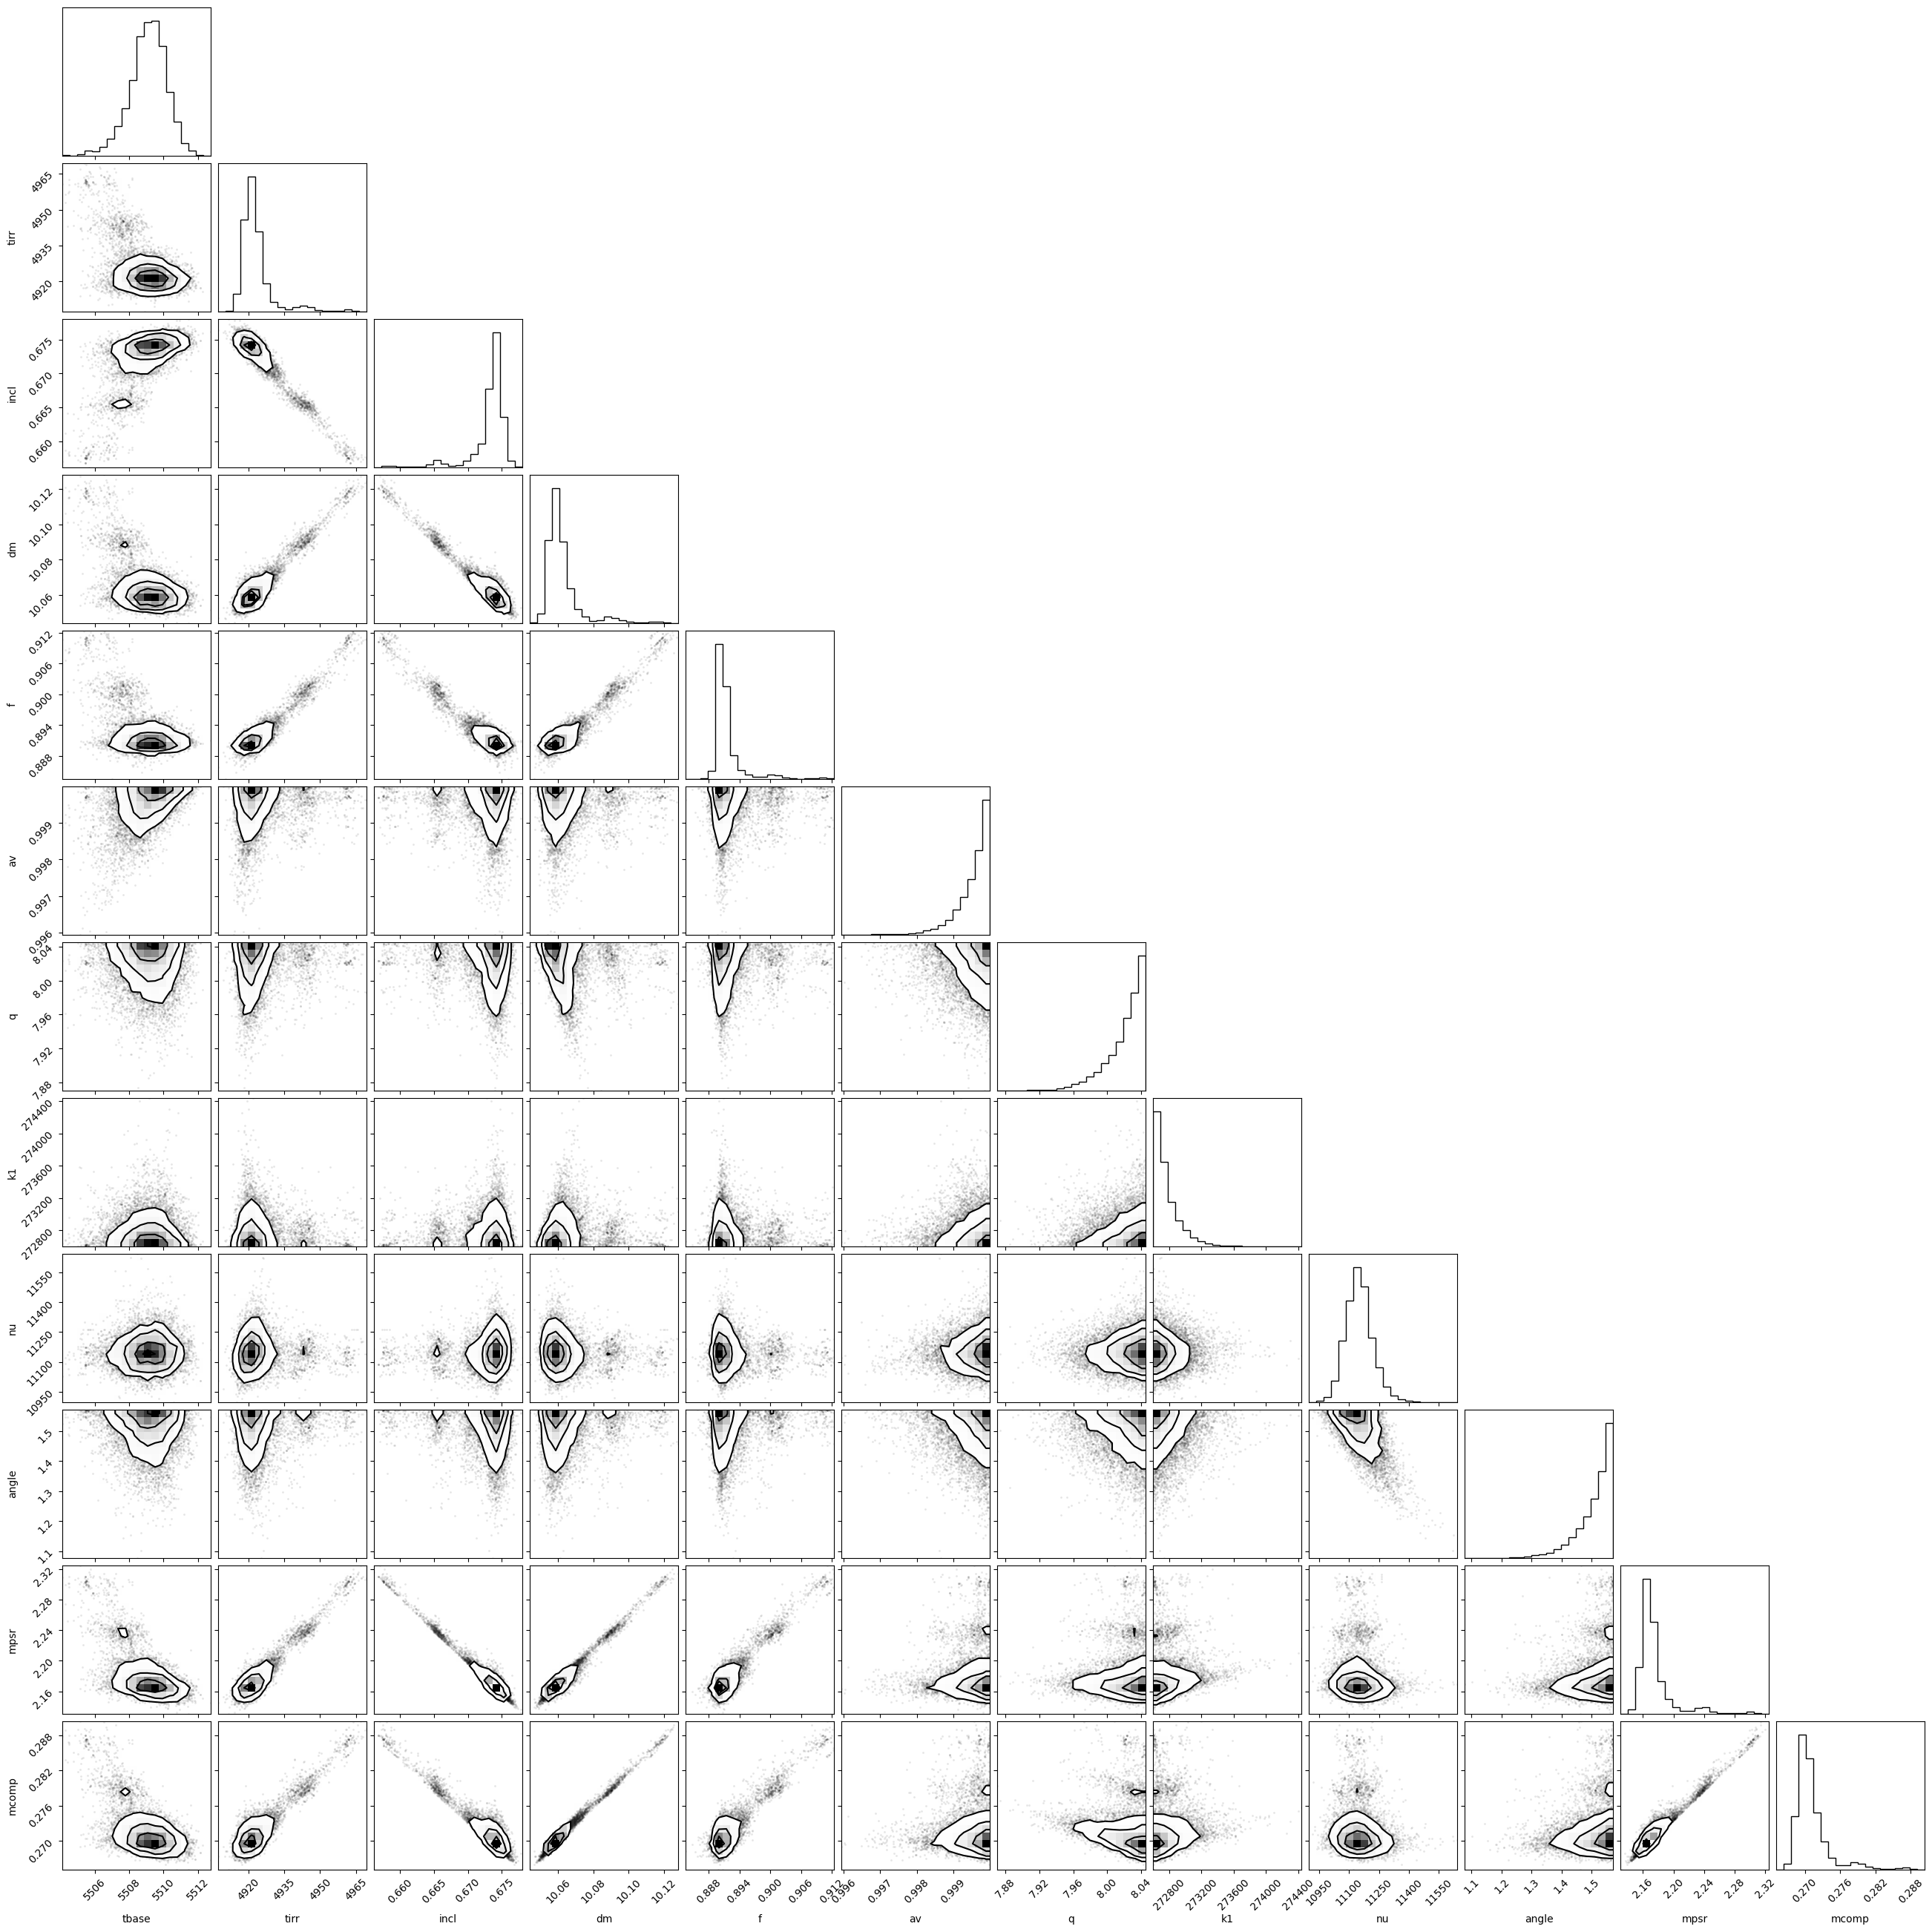

In [198]:
ig = corner.corner(
    flat_samples3, labels=labels, truths=[tbase_true, tirr_true, incl_true, dm_true, f_true, av_true, q_true, k_true, nu_true, ang_true, mpsr_true, mcomp_true]
);


In [199]:
answers = []

In [200]:
for i in range(ndim+2):
    mcmc = np.percentile(flat_samples3[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    answers.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [62]:
incldeg = answers[2] * 180 / np.pi
print(incldeg)

38.60943025292949


In [203]:
answers

[5509.158514169317,
 4921.713471366994,
 0.6738616802327266,
 10.059543156536176,
 0.8907409683176044,
 0.9996757142114345,
 8.027184702308066,
 272718.4809869791,
 11147.358614422345,
 1.526425388266176,
 2.168797926030254,
 0.2703956414423037]

In [71]:
## creating an updated dictionary with the results

ipu = {'q'        : answers[6], # Mass ratio, M2/M1 (m2 = nstar)/(m1 = companion)
      'porb'     : 0.1980962019*24*60*60, # Porb, in seconds
      'incl'     : answers[2], # Inclination, in radians
      'k1'       : answers[7], # Projected radial velocity of the companion in m/s
      'omega'    : 1.0, # Co-rotation factor, always=1.0
      'filling'  : answers[4], # Ratio of the secondary's radius along the line joining both stars to the distance to the L1 point.
      'tempgrav' : 0.25, #Exponent of the temperature dependance for gravity darkening. For a radiative core, = 0.25, for a fully convective star = 0.08.
      'temp'     : {'tbase': answers[0], # The temperature of the cells of the companion prior to gravity darkening or to irradiation
                    'tirr' : answers[1], # T**4 = Tbase**4+Tirr**4 (F=Fbase+Firr)
                    'diffusion' : {'kappa': 0,
                                       'difindex': 0.0},
                    'convection' : [answers[8],answers[9],np.pi/2]
                       },
      'dm'       : answers[3], # distance modulus
      'av'       : answers[5]} # Extinction in magnitudes of the object at Johnson V band.

In [125]:
# updating the photometry
phot = Icarus.Photometry.Photometry_diffusion(atmo_fln="all_atmo.txt",
                                          data_fln="all_data.txt",
                                          ndiv=8, lmax=20, accuracy=100,
                                          SHMultiplicator_file="SHmultiplicators_schmidt_csphase-1_lmax30.npz",
                                          polar_convection_profile='Gauss')

In [126]:
# updating the model
model_1u = phot.Get_flux(ipu, influx = True)

astropy                        _showwarning             :         WARNING AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
healpy                         smoothalm                :         INFO   Sigma is 0.000000 arcmin (0.000000 rad) 
healpy                         smoothalm                :         INFO   -> fwhm is 0.000000 arcmin


Text(0, 0.5, 'Flux')

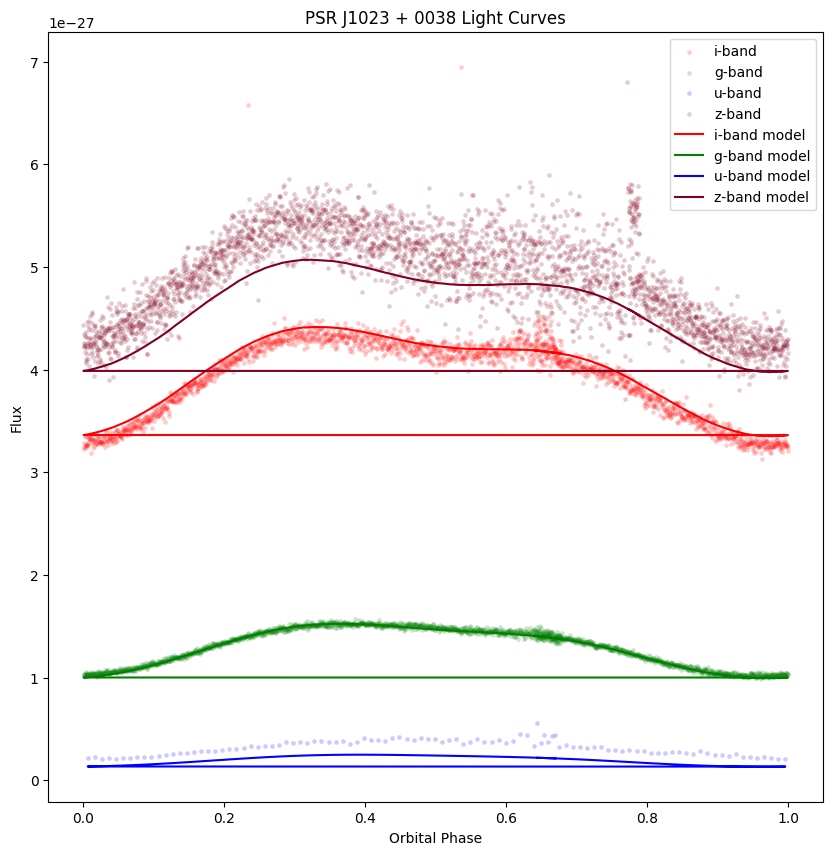

In [127]:
plt.rcParams['figure.figsize'] = [10, 10]
# data lightcurve
plt.scatter(phot.data['phase'][0], phot.data['flux'][0], label='i-band', marker = '.', color = 'r', linewidths = 0.2, alpha = 0.2)
plt.scatter(phot.data['phase'][1], phot.data['flux'][1], label='g-band', marker = '.', color = 'g', linewidths = 0.2, alpha = 0.2)
plt.scatter(phot.data['phase'][2], phot.data['flux'][2], label='u-band', marker = '.', color = 'b', linewidths = 0.2, alpha = 0.2)
plt.scatter(phot.data['phase'][3], phot.data['flux'][3], label='z-band', marker = '.', color = '#800020', linewidths = 0.2, alpha = 0.2)

# model lightcurve
plt.plot(phot.data['phase'][0], model_1u[0], label='i-band model', color = 'r')
plt.plot(phot.data['phase'][1], model_1u[1], label='g-band model', color = 'g')
plt.plot(phot.data['phase'][2], model_1u[2], label='u-band model', color = 'b')
plt.plot(phot.data['phase'][3], model_1u[3], label='z-band model', color = '#800020')


ax = plt.gca()
##ax.invert_yaxis()

plt.legend()

plt.title('PSR J1023 + 0038 Light Curves')

plt.xlabel('Orbital Phase')
plt.ylabel('Flux')

In [128]:
# calculating the chi2
print(phot.Calc_chi2(ipu, do_offset=True, full_output=False, influx=True))
datapoints = len(phot.data['flux'][0]) + len(phot.data['flux'][1]) + len(phot.data['flux'][2]) + len(phot.data['flux'][3])
chi2 = phot.Calc_chi2(ipu, do_offset=True, full_output=False, influx=True)

30588.04857415054


In [129]:
#calculating the reduced chi2
redchi2 = chi2 / datapoints
print(redchi2)

4.474553624071174


In [130]:
print(phot.Calc_chi2(ipu, do_offset=True, full_output=True, influx=True))
datapoints = len(phot.data['flux'][0]) + len(phot.data['flux'][1]) + len(phot.data['flux'][2]) + len(phot.data['flux'][3])
chi2, results = phot.Calc_chi2(ipu, do_offset=True, full_output=True, influx=True)

(30588.04857415054, {'offset': array([ 0.02075807, -0.0110489 , -0.48919008, -0.06446393]), 'par': {'q': 8.027184702308066, 'porb': 17115.51184416, 'incl': 0.6738616802327266, 'k1': 272718.4809869791, 'omega': 1.0, 'filling': 0.8907409683176044, 'tempgrav': 0.25, 'temp': {'tbase': 5509.158514169317, 'tirr': 4921.713471366994, 'diffusion': {'kappa': 0, 'difindex': 0.0}, 'convection': [11147.358614422345, 1.526425388266176, 1.5707963267948966]}, 'dm': 10.059543156536176, 'av': 0.9996757142114345}, 'res': [array([ 2.18634611,  3.93442182,  2.38716998, ...,  3.80872838,
        3.17658827, -0.94626108]), array([-0.19934064, -0.23397441, -1.15462123, ..., -0.10269587,
       -0.14711584,  1.11336904]), array([ 0.06214268,  0.36847664,  0.38779461, -0.24287783,  0.3920811 ,
        0.01036275,  0.06182059,  0.1487318 ,  0.3376527 ,  0.5293825 ,
       -0.05735252,  0.27156232,  0.00881079,  0.35022083,  0.48770425,
        0.40102337,  0.12890664,  0.52718338,  0.45374316,  0.72770106,
     

Text(0, 0.5, 'Flux')

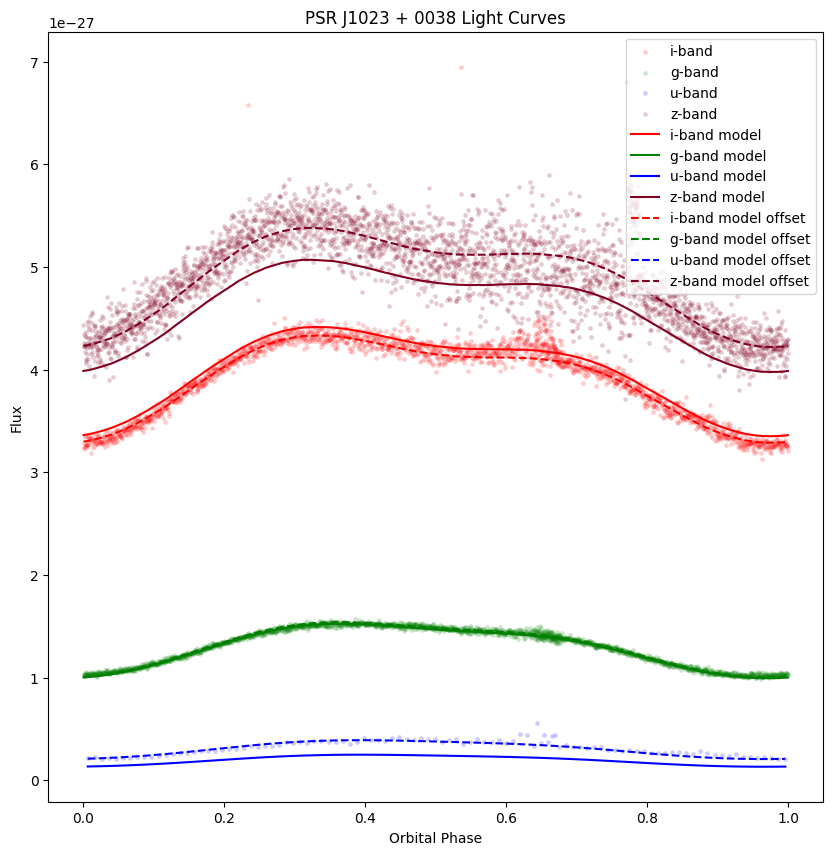

In [158]:
# plotting the data lightcurves
plt.scatter(phot.data['phase'][0], phot.data['flux'][0], label='i-band', marker = '.', color = 'r', linewidths = 0.2, alpha = 0.2)
plt.scatter(phot.data['phase'][1], phot.data['flux'][1], label='g-band', marker = '.', color = 'g', linewidths = 0.2, alpha = 0.2)
plt.scatter(phot.data['phase'][2], phot.data['flux'][2], label='u-band', marker = '.', color = 'b', linewidths = 0.2, alpha = 0.2)
plt.scatter(phot.data['phase'][3], phot.data['flux'][3], label='z-band', marker = '.', color = '#800020', linewidths = 0.2, alpha = 0.2)
#plotting the model lightcurves
plt.plot(phot.data['phase'][0][np.argsort(phot.data['phase'][0])], model_1u[0][np.argsort(phot.data['phase'][0])], label='i-band model', color = 'r')
plt.plot(phot.data['phase'][1][np.argsort(phot.data['phase'][1])], model_1u[1][np.argsort(phot.data['phase'][1])], label='g-band model', color = 'g')
plt.plot(phot.data['phase'][2][np.argsort(phot.data['phase'][2])], model_1u[2][np.argsort(phot.data['phase'][2])], label='u-band model', color = 'b')
plt.plot(phot.data['phase'][3][np.argsort(phot.data['phase'][3])], model_1u[3][np.argsort(phot.data['phase'][3])], label='z-band model', color = '#800020')
# plotting the offset lightcurves
plt.plot(phot.data['phase'][0][np.argsort(phot.data['phase'][0])], model_1u[0][np.argsort(phot.data['phase'][0])]*10**(results['offset'][0]/-2.5), label='i-band model offset', color = 'r', linestyle = 'dashed')
plt.plot(phot.data['phase'][1][np.argsort(phot.data['phase'][1])], model_1u[1][np.argsort(phot.data['phase'][1])]*10**(results['offset'][1]/-2.5), label='g-band model offset', color = 'g', linestyle = 'dashed')
plt.plot(phot.data['phase'][2][np.argsort(phot.data['phase'][2])], model_1u[2][np.argsort(phot.data['phase'][2])]*10**(results['offset'][2]/-2.5), label='u-band model offset', color = 'b', linestyle = 'dashed')
plt.plot(phot.data['phase'][3][np.argsort(phot.data['phase'][3])], model_1u[3][np.argsort(phot.data['phase'][3])]*10**(results['offset'][3]/-2.5), label='z-band model offset', color = '#800020', linestyle = 'dashed')


ax = plt.gca()
##ax.invert_yaxis()

plt.legend()

plt.title('PSR J1023 + 0038 Light Curves')

plt.xlabel('Orbital Phase')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

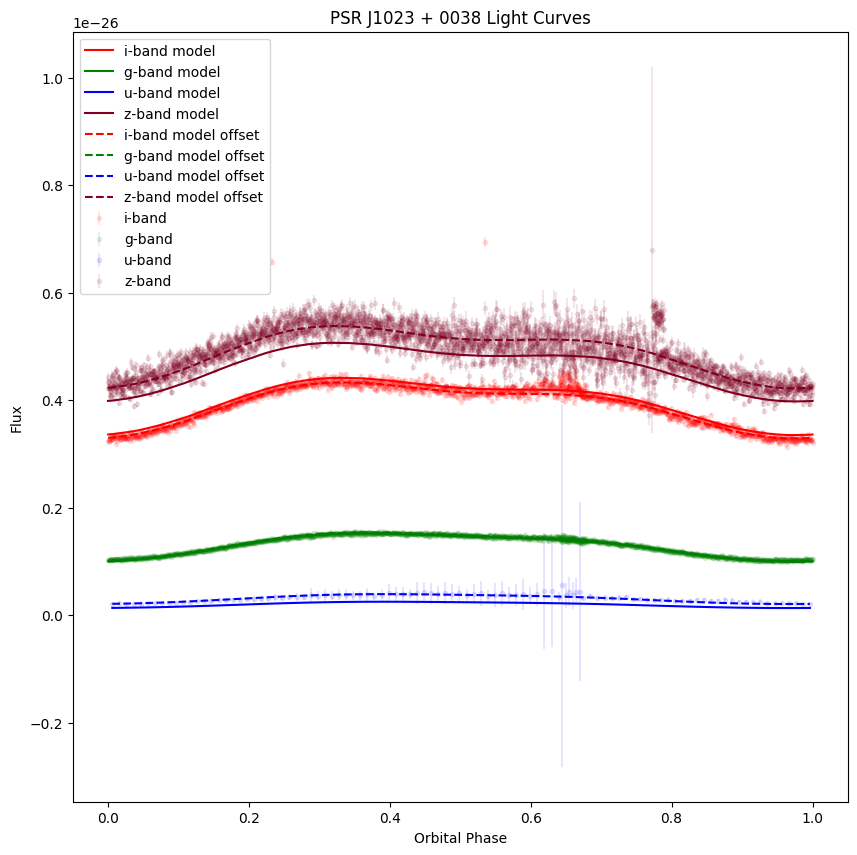

In [201]:
#plotting with errorbars
plt.rcParams['figure.figsize'] = [10, 10]
# data lightcurves
plt.errorbar(phot.data['phase'][0], phot.data['flux'][0], label='i-band',yerr=phot.data['flux_err'][0],fmt='.', color = 'r', alpha = 0.1)
plt.errorbar(phot.data['phase'][1], phot.data['flux'][1], label='g-band',yerr=phot.data['flux_err'][1],fmt='.', color = 'g', alpha = 0.1)
plt.errorbar(phot.data['phase'][2], phot.data['flux'][2], label='u-band',yerr=phot.data['flux_err'][2],fmt='.', color='b', alpha = 0.1)
plt.errorbar(phot.data['phase'][3], phot.data['flux'][3], label='z-band',yerr=phot.data['flux_err'][3],fmt='.', color='#800020', alpha = 0.1)
# model lightcurves
plt.plot(phot.data['phase'][0][np.argsort(phot.data['phase'][0])], model_1u[0][np.argsort(phot.data['phase'][0])], label='i-band model', color = 'r')
plt.plot(phot.data['phase'][1][np.argsort(phot.data['phase'][1])], model_1u[1][np.argsort(phot.data['phase'][1])], label='g-band model', color = 'g')
plt.plot(phot.data['phase'][2][np.argsort(phot.data['phase'][2])], model_1u[2][np.argsort(phot.data['phase'][2])], label='u-band model', color = 'b')
plt.plot(phot.data['phase'][3][np.argsort(phot.data['phase'][3])], model_1u[3][np.argsort(phot.data['phase'][3])], label='z-band model', color = '#800020')
# model lightcurves with offset
plt.plot(phot.data['phase'][0][np.argsort(phot.data['phase'][0])], model_1u[0][np.argsort(phot.data['phase'][0])]*10**(results['offset'][0]/-2.5), label='i-band model offset', color = 'r', linestyle = 'dashed')
plt.plot(phot.data['phase'][1][np.argsort(phot.data['phase'][1])], model_1u[1][np.argsort(phot.data['phase'][1])]*10**(results['offset'][1]/-2.5), label='g-band model offset', color = 'g', linestyle = 'dashed')
plt.plot(phot.data['phase'][2][np.argsort(phot.data['phase'][2])], model_1u[2][np.argsort(phot.data['phase'][2])]*10**(results['offset'][2]/-2.5), label='u-band model offset', color = 'b', linestyle = 'dashed')
plt.plot(phot.data['phase'][3][np.argsort(phot.data['phase'][3])], model_1u[3][np.argsort(phot.data['phase'][3])]*10**(results['offset'][3]/-2.5), label='z-band model offset', color = '#800020', linestyle = 'dashed')


ax = plt.gca()
##ax.invert_yaxis()

plt.legend()

plt.title('PSR J1023 + 0038 Light Curves')

plt.xlabel('Orbital Phase')
plt.ylabel('Flux')